In [148]:
from IPython.display import Image
from local_utils import *

###  Эффект на скор: 

| Действия  | Score | $\Delta_{prev}$ | $\Delta_{base}$|
|-----------|-------|----------|-------|
| baseline | 0.8173 | 0 | 0 |
|<th colspan="4"> Фильтрация val </th>|
| A1 | 0.8176 | +0.0003 | +0.0003 |
| A2 | 0.8186 | +0.0010 | +0.0013 |
|<th colspan="4"> Генерация фичей </th>|
| B | 0.8208 | +0.0022 | +0.0035 |
| C | 0.8202 | -0.0006 | +0.0029 |
|<th colspan="4"> Интерпретация построенных моделей град. бустинга  (Отбор фичей) </th>|
| D | 0.8237 | +0.0035 | +0.0064 |
|<th colspan="4">  Понижение размерности + Кластеризация </th>|
| E | 0.8233 | -0.0004 | +0.0060 |
|<th colspan="4"> Тюнинг гиперпараметров бустинга  </th>|
| F | 0.8235 | +0.0002 | +0.0062 |

## Фильтрация null в val

### A: 

- **Засемплировать объекты** из val где все null во всех колонках в количестве 8% (частота в тесте)
- **Отфильтровать** val от null во всех строках.

## Генерация признаков (5 баллов):

### B: аггрегаты

- **Группировка данных**:
  - По полям `user_id` и `timestamp` (так как в одном action могло быть несколько продуктов (например покупка нескольких штук))
  - Суммирование стоимости и количества товаров в рамках каждой группы = сумма за 1 `timestamp` у каждого юзера

- **Расчёт агрегатов**:
  - Основные метрики: `sum` `avg` `max` 
  - Аналогичные месячные агрегаты (за каждый месяц за 4 месяца до предикта)

- **Дополнительные метрики**:
  - `spent_change_ratio` = `avg_month_1` / `avg_total`  
    _(отношение средних трат в последний месяц к среднему за весь период)_
  - `is_returning_customer` = количество месяцев с заказами  
    _(индикатор возвращаемости клиента)_
  - `loyalty_duration` = `max(timestamp) - min(timestamp)`  
    _(длительность "лояльности" клиента)_

### С: категориальные

- Добавил **категориальные колонки** - самый частый продукт в action

## Интерпретация построенных моделей град. бустинга (5 баллов)

### D: отбор фичей

- Отбираю **лучшие 50 фичей** по feature importance (num + cat)

#### Отбираю лучшие 50 num фичей по feature importance + shap_value

также глазами посмотрел на графики beeswarm. и не беру фичи которые сильно перемешаны их значения слабо корелируют с shap value, и значит они будут путать модель

In [32]:
fi = model.get_feature_importance(eval_pool, prettified=True)
fi.head(50)

,Feature Id,Importances
0,sum_num_products_order_by_month_1,5.353556
1,has_order_by_month_1,4.641602
2,mean_time_between_order,4.559544
3,days_since_last_order,4.438459
4,days_since_first_order_by_month_1,2.549199
5,max_discount_delta_order_by_month_1,2.535443
6,sum_num_products_click,2.456952
7,max_discount_price_per_onetime_to_cart,2.325308
8,max_time_between_order_by_month_1,2.264016
9,mean_time_between_order_by_month_1,2.257132


In [41]:
df_shap_values = pd.DataFrame(data=shap_values.values,columns=num_cols)
df_feature_importance = pd.DataFrame(columns=['feature','importance'])
for col in df_shap_values.columns:
    importance = df_shap_values[col].abs().mean()
    df_feature_importance.loc[len(df_feature_importance)] = [col,importance]
df_feature_importance = df_feature_importance.sort_values('importance',ascending=False)

In [85]:
fi_list = fi['Feature Id'].to_list()[:50]
good_features = df_feature_importance.iloc[:50].feature.to_list()

best_cols = fi_list + good_features
best_cols = list(set(best_cols))

cols = best_cols

####  отбираю категориальные фичи с помощью shadow cats

In [160]:
tr, val = get_split(df_pd, val_size=0.23)
model_with_rnd, shadow_features, tr_rnd, val_rnd = train_model(tr, val, cols, 'target', params={'importance_type': 'gain'},
                                                               shadow_features=True, sklearn_style=True)
rnd_features = np.r_[cols, shadow_features]
shadow_features

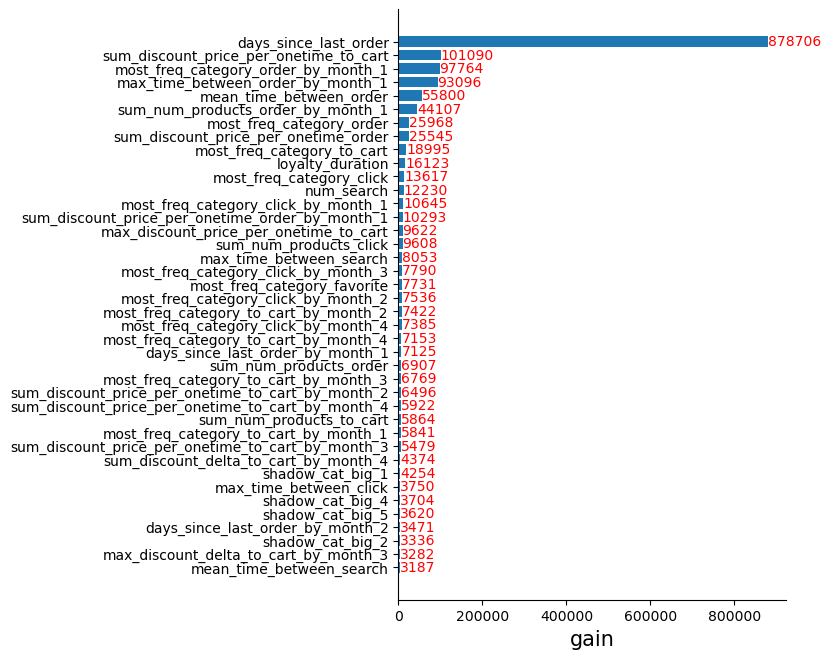

In [126]:
plot_lgbm_importance(model_with_rnd, rnd_features, importance_type='gain', top_k=40, sklearn_style=True)

Видим, что часть категориальных признаков является мусором - нахоятся под shadow_cats по gain. Так как lgbm может подогнать сплит в категориальных фичах чтобы увеличить gain. Не берем их в модель.

## Понижение размерности (5 баллов) + Кластеризация (5 баллов):

### E: 

- Добавил категориальную колонку **cluster** по значениям из shap value

На Shap values взял стратифицированный сэмпл по колонке с самым большим влиянием (days_since_last_order) + target. 5% выборки = 60к объектов. Взял Umap эмбеддинги и построил кластеризацию. Получил N кластеров. 

Обучил lgbm модель определять кластер на 5% и предсказал для всей выборки. Добавил как колонку.

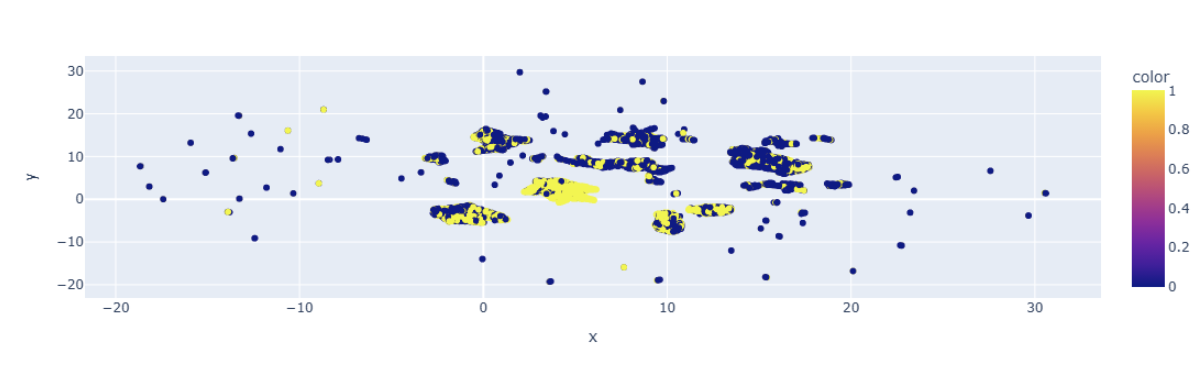

In [150]:
Image('umap.png')

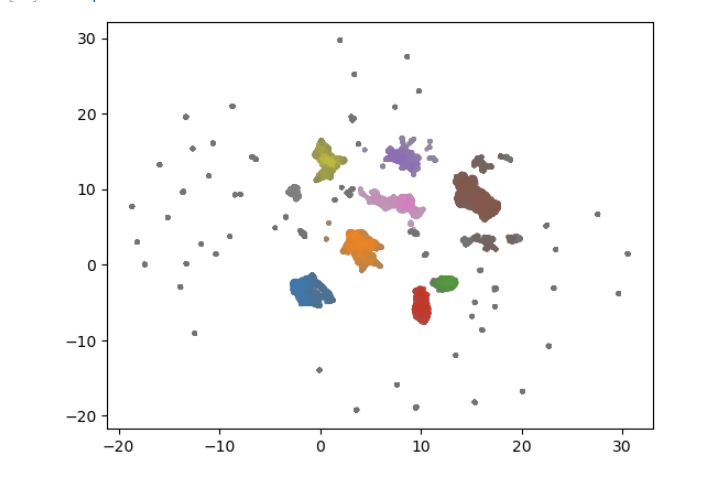

In [152]:
Image('hdbscan.png')

## Тюнинг гиперпараметров бустинга (5 баллов)

### F: При помощи optunы перебрал параметры eta, depth, score_function

In [ ]:
params = {
    'iterations': 200,
    'depth': trial.suggest_int('depth', 3, 10),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1, log=True, step=None),
    'random_state': 1,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'task_type': 'CPU',
    'score_function': trial.suggest_categorical('score_function',['L2', 'Cosine']),
}

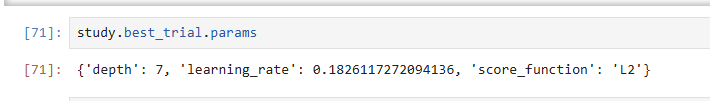

In [9]:
Image('optuna.png')